In [14]:
import numpy as np
import matplotlib.pyplot as plt

percentiles=np.load('/Users/patriglesiasnavarro/Desktop/ULL/Master/Segundo/TFM/programas/github/BNN_SFHs/spender/saved_input/percentiles.npy')

percentiles_0

Text(0, 0.5, 'Mass/Mtotal * 100 %')

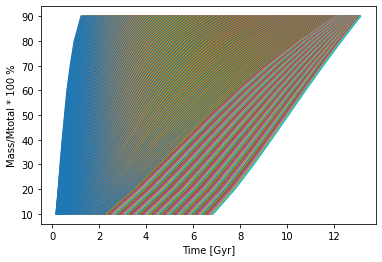

In [6]:
for i in range(10000):
    plt.plot(percentiles[i,:],np.arange(10,100,10))
plt.xlabel('Time [Gyr]')
plt.ylabel('Mass/Mtotal * 100 %')

The SFH are the derivative of the curves of growth (with percentiles). Notice our Ys are the percentages, and our Xs the time of each percentil

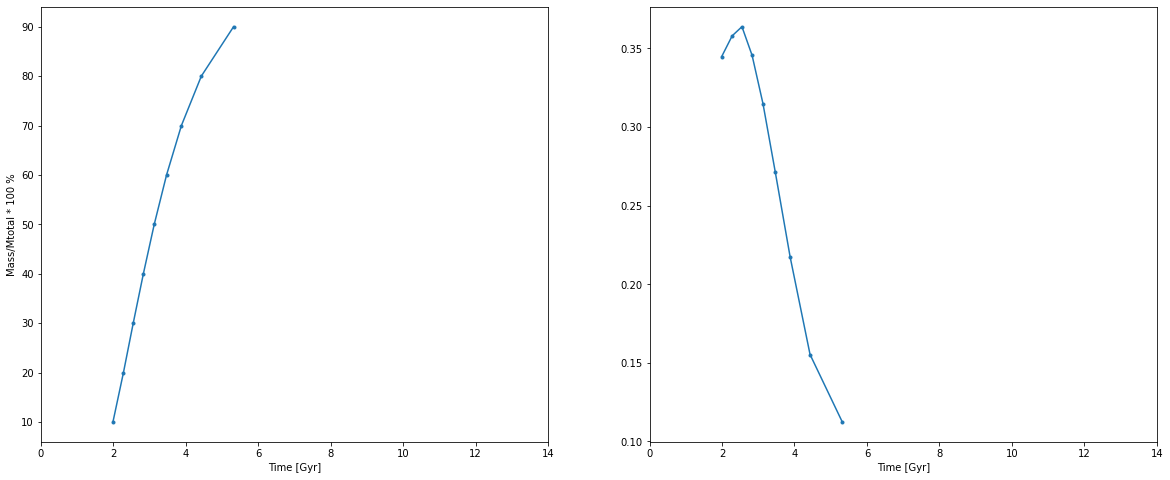

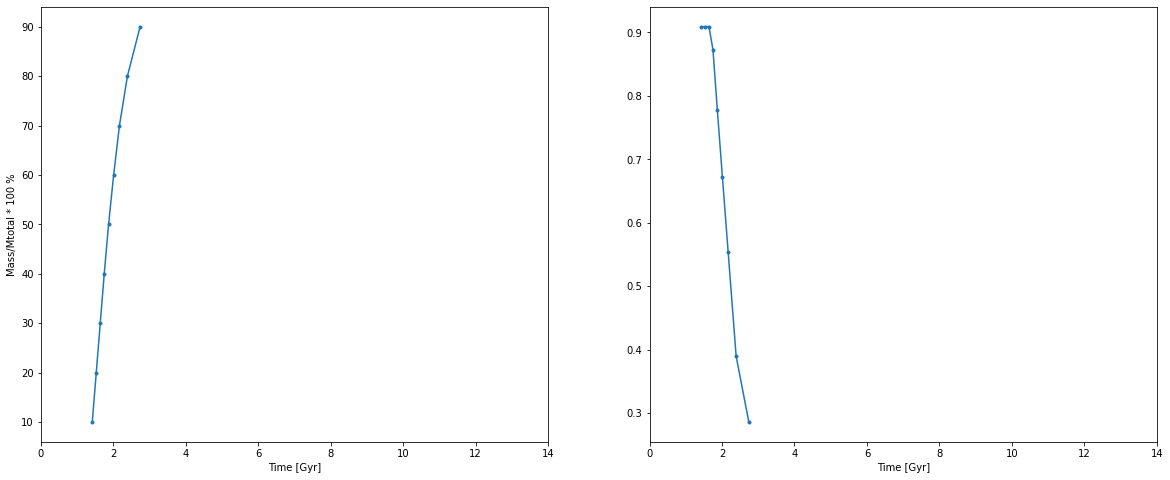

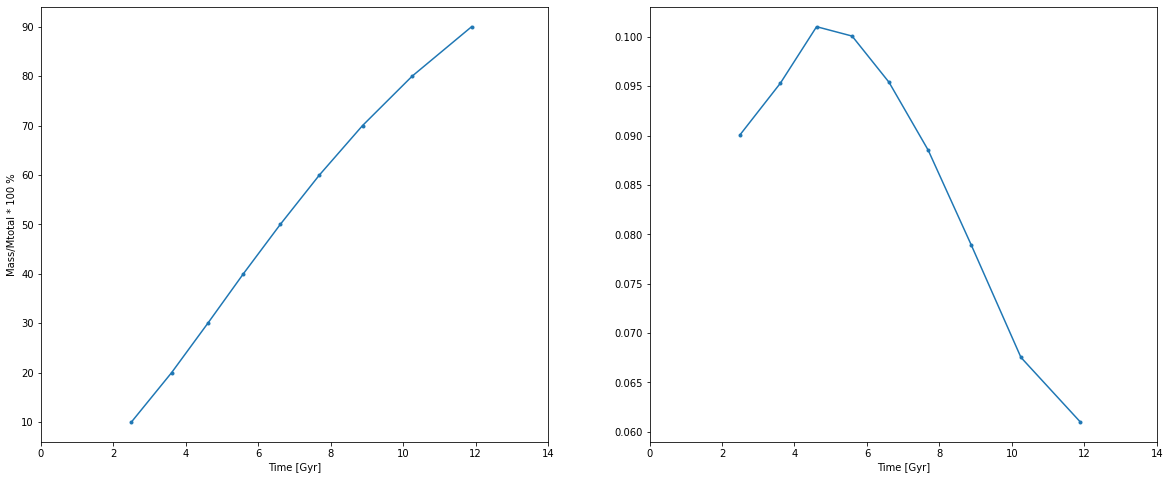

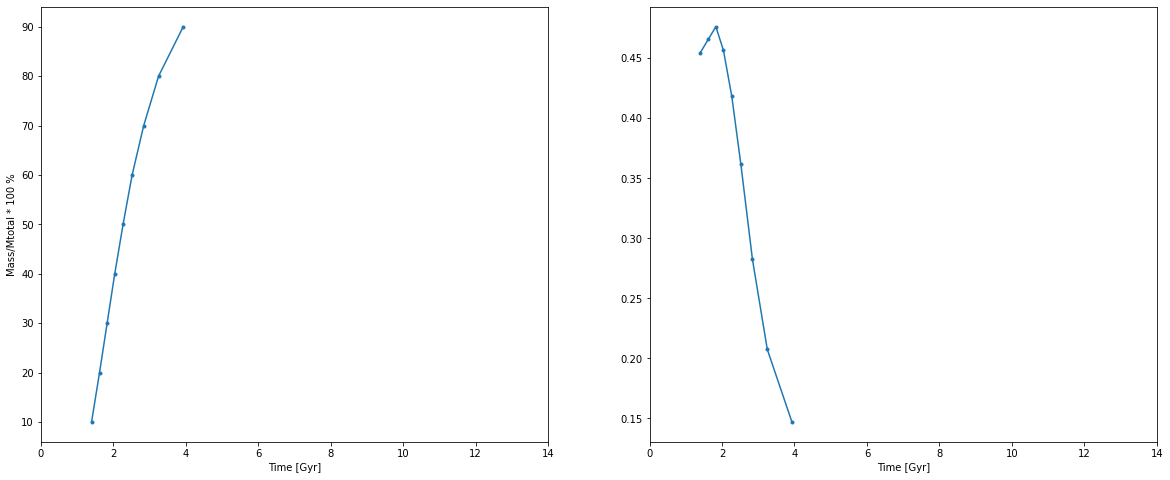

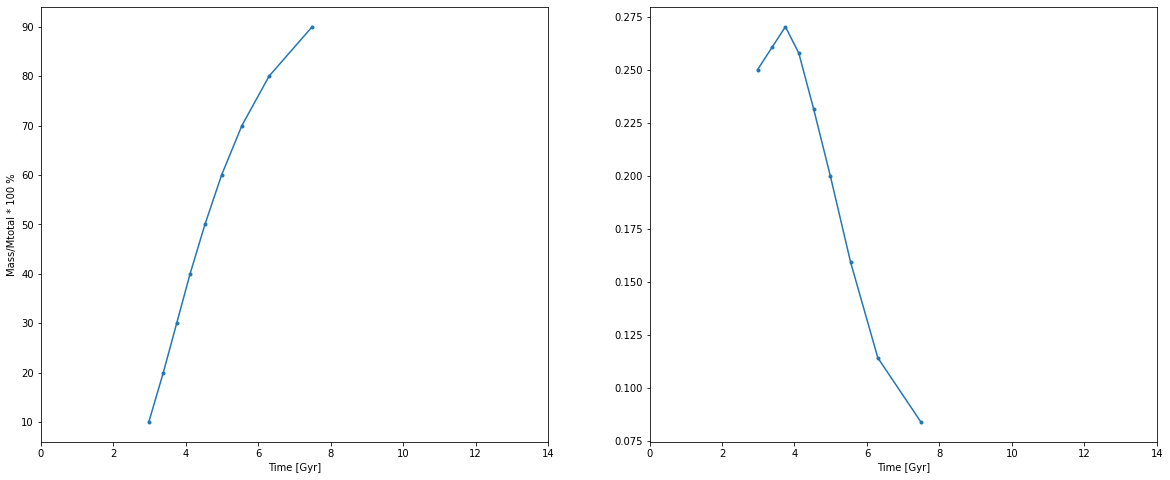

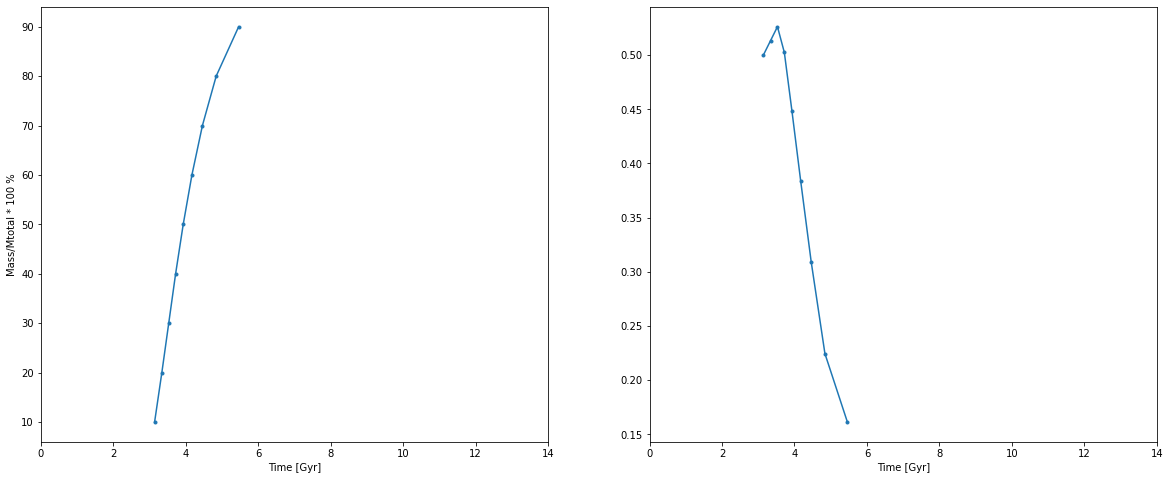

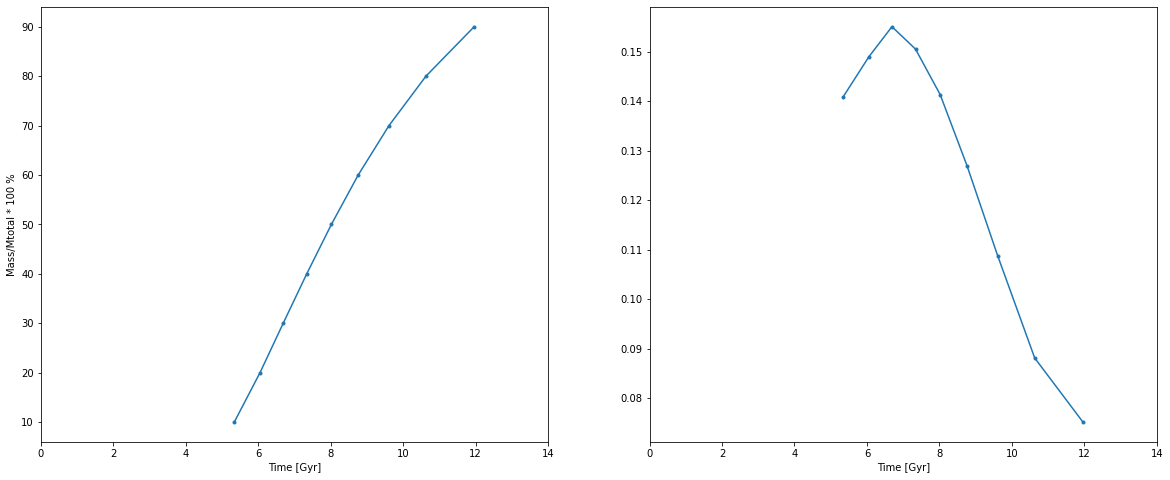

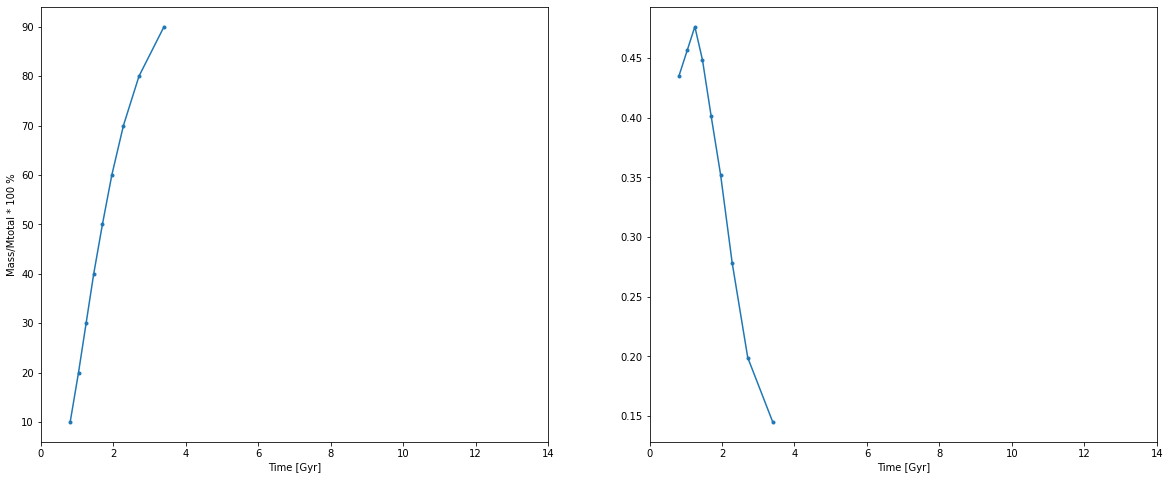

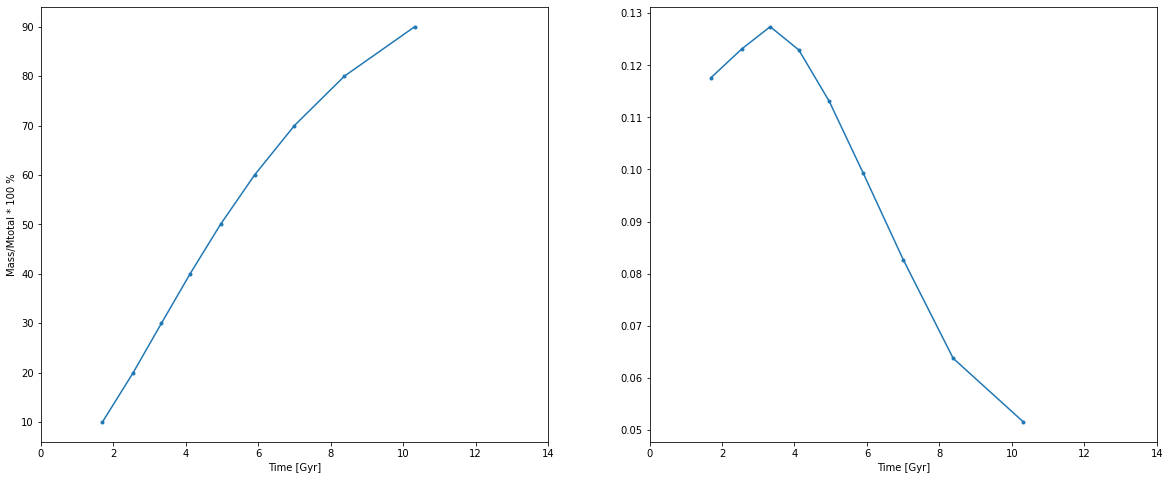

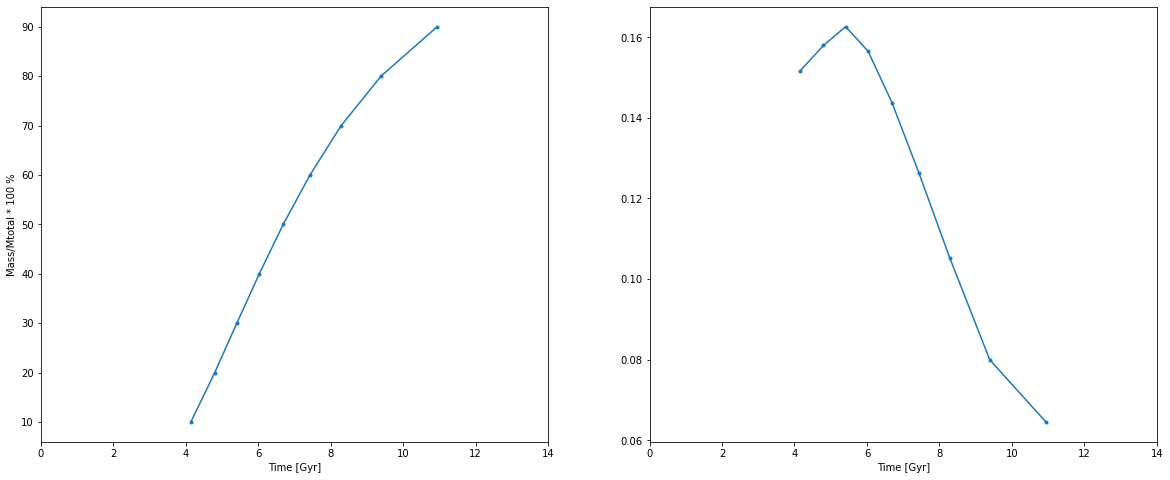

In [20]:
for i in np.random.randint(0,10000,10):
    per=percentiles[i,:]
    t=np.copy(per)
    ms=np.gradient(np.arange(0.1,1,0.1),t)
    
    plt.figure(figsize=(20,8))
    
    plt.subplot(121)
    plt.plot(per[:],np.arange(10,100,10),'.-')
    plt.xlim(0,14)
    plt.xlabel('Time [Gyr]')
    plt.ylabel('Mass/Mtotal * 100 %')
    
    plt.subplot(122)
    plt.plot(t,ms,'.-')
    plt.xlim(0,14)
    plt.xlabel('Time [Gyr]')
    
    plt.show()



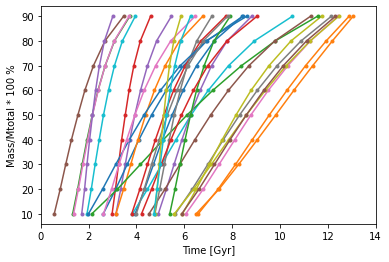

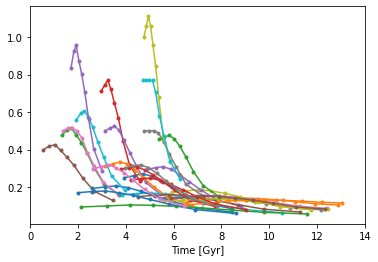

In [25]:
index_list=np.random.randint(0,10000,30)

for k,i in enumerate(index_list):
    per=percentiles[i,:]
    t=np.copy(per)
    ms=np.gradient(np.arange(0.1,1,0.1),t)
    
    plt.plot(per[:],np.arange(10,100,10),'.-',color='C'+str(k))
    plt.xlim(0,14)
    plt.xlabel('Time [Gyr]')
    plt.ylabel('Mass/Mtotal * 100 %')
plt.show()
    
for k,i in enumerate(index_list):
    per=percentiles[i,:]
    t=np.copy(per)
    ms=np.gradient(np.arange(0.1,1,0.1),t)
    
    plt.plot(t,ms,'.-',color='C'+str(k))
    plt.xlim(0,14)
    plt.xlabel('Time [Gyr]')
plt.show()